In [2]:
# Load packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import linear_model

In [3]:
# Set the style of display
plt.style.use("ggplot")
%matplotlib inline

In [4]:
data = pd.read_csv('./data/image_database.txt')

In [5]:
data.columns

Index([u'starname', u'ra_act', u'dec_act', u'x_act_mx1', u'x_act_mx2',
       u'x_act_mx3', u'x_act_my3', u'x_act_my4', u'x_act_px1', u'x_act_px2',
       u'x_act_px3', u'x_act_py1', u'x_act_py2', u'x_act_py3', u'x_act_py4',
       u'x_img_mx1', u'x_img_mx2', u'x_img_mx3', u'x_img_my3', u'x_img_my4',
       u'x_img_px1', u'x_img_px2', u'x_img_px3', u'x_img_py1', u'x_img_py2',
       u'x_img_py3', u'x_img_py4', u'y_act_mx1', u'y_act_mx2', u'y_act_mx3',
       u'y_act_my3', u'y_act_my4', u'y_act_px1', u'y_act_px2', u'y_act_px3',
       u'y_act_py1', u'y_act_py2', u'y_act_py3', u'y_act_py4', u'y_img_mx1',
       u'y_img_mx2', u'y_img_mx3', u'y_img_my3', u'y_img_my4', u'y_img_px1',
       u'y_img_px2', u'y_img_px3', u'y_img_py1', u'y_img_py2', u'y_img_py3',
       u'y_img_py4', u'v_global_x', u'v_global_y', u'v_global_z',
       u'err_mag_mx3', u'err_r_mx3', u'err_ang_mx3', u'err_mag_py3',
       u'err_r_py3', u'err_ang_py3', u'err_mag_my3', u'err_r_my3',
       u'err_ang_my3', u'err_mag_p

In [6]:
def fetch_data(camera, image_num):
    """ Fetches the star data from a given image taken from a given camera
    Parameters
    ----------
    camera : str
        The camera name
    image_num: str
        The number of an image from a camera. 
        If set to ".", all the images will be returned
        
    Returns
    -------
    Pandas.DataFrames
        Returns a data fram with NaN entries removed
    """
    # Load all the star data
    data = pd.read_csv('./data/image_database.txt')
    
    # Fetch the data of interest set by "camera" and "image_num"
    regex_txt = "err_.*" + camera + image_num
    df = data.filter(regex=regex_txt)
    
    return df

In [7]:
# Fetch all the data taken from camera "mx" 
camera = "mx"
image_num = "."

df = fetch_data(camera, image_num)
df.head()

,err_mag_mx3,err_r_mx3,err_ang_mx3,err_mag_mx2,err_r_mx2,err_ang_mx2,err_mag_mx1,err_r_mx1,err_ang_mx1
0,NaN,NaN,84.859260,NaN,NaN,84.859260,NaN,NaN,84.859260
1,NaN,NaN,34.887684,NaN,NaN,34.887684,NaN,NaN,34.887684
2,NaN,NaN,94.018541,NaN,NaN,94.018541,NaN,NaN,94.018541
3,NaN,NaN,93.243282,NaN,NaN,93.243282,NaN,NaN,93.243282
4,NaN,NaN,93.064243,NaN,NaN,93.064243,NaN,NaN,93.064243


In [8]:
df.describe()

,err_mag_mx3,err_r_mx3,err_ang_mx3,err_mag_mx2,err_r_mx2,err_ang_mx2,err_mag_mx1,err_r_mx1,err_ang_mx1
count,112.000000,112.000000,98.000000,115.000000,115.000000,98.000000,21.000000,21.000000,98.000000
mean,1.708790,542.145293,101.438478,2.156539,531.218733,101.438478,0.929675,563.367564,101.438478
std,0.727047,263.917057,27.460691,0.625118,251.130435,27.460691,0.611878,186.577424,27.460691
min,0.111400,9.102225,15.155884,0.386588,9.218313,15.155884,0.082680,156.328580,15.155884
25%,1.263753,348.696906,82.916111,1.643794,356.533943,82.916111,0.627360,532.972339,82.916111
50%,1.744043,606.238980,105.832814,2.153845,596.907934,105.832814,0.823817,613.679713,105.832814
75%,2.171537,745.952198,116.660812,2.685418,740.612167,116.660812,1.076075,658.501959,116.660812
max,3.359036,1013.690734,170.359913,3.149516,1009.864620,170.359913,3.119703,816.381060,170.359913


## Build a Regression Model


### Create Features and Split the Data 

In [19]:
def prepare_data(df, camera, image_nums=["1", "2"]):
    """ Prepares the data for training and testing
    """
    x = []
    y = []
    for l in image_nums:
            regex_txt = "err_.*" + camera + l
            dfn = df.filter(regex=regex_txt)
            dfn.dropna(inplace=True)
            cols = ["err_mag_" + camera + l, "err_ang_"+ camera + l]
            df_tmp = dfn.loc[:, cols]
            y.append(df_tmp.as_matrix())
            #cols = ["err_r_" + camera + l, "x_img_" + camera + l, "y_img_" + camera + l]
            cols = ["err_r_" + camera + l]
            df_tmp = dfn.loc[:, cols]
            x.append(df_tmp.as_matrix())
            
    y = np.vstack(tuple(y))
    x = np.vstack(tuple(x))
    return x, y

#y_train = np.reshape(df.err_mag_mx2.as_matrix(), (df.shape[0], 1))
#x_train = np.reshape(df.err_r_mx2.as_matrix(), (df.shape[0], 1))

# Create the training and test datasets
x_train, y_train = prepare_data(df, camera, image_nums=["1", "2"])
x_test, y_test = prepare_data(df, camera, image_nums=["3"])

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

# Create polynomial features
#x_train_poly = np.hstack((x_train, np.power(x_train,2), np.power(x_train,3)))
#poly = preprocessing.PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
#x_train_poly=poly.fit_transform(x_train)

# Fit a linear regression model
#LR = linear_model.LinearRegression(normalize=True)
#LR.fit(x_train_poly, y_train)

/home/sd-spare/muhammad/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Build Models

In [ ]:
# use mean absolute error as model eveluation metrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    """
    Parameters
    ----------
    learner :  
        the learning algorithm to be trained and predicted on
    sample_size : int
        the size of samples (number) to be drawn from training set
    X_train : Pandas.DataFrame 
        predictors in training set
    y_train : Pandas.DataFrame
        response in training set
    X_test : Pandas.DataFrame
        predictors in testing set
    y_test : Pandas.DataFrame
        response in testing set
        
    Returns
    -------
    dict
        a dictionalry object that holdes various results related to model eveluation 
    """
    
    from time import time
    
    results = {}
    
    # fit the learner to the training data using slicing with 'sample_size'
    X_train_sample = X_train[:sample_size]
    y_train_sample = y_train[:sample_size]
    start = time() # Get start time
    learner = learner.fit(X_train_sample, y_train_sample)
    end = time() # Get end time
    
    # calculate the training time
    results['train_time'] = end - start
        
    # get the predictions on the test set,
    # then get predictions on the training set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_sample)
    end = time() # Get end time
    
    # store the predictions
    results['yhat_train'] = predictions_train
    results['yhat_test'] = predictions_test
    
    # calculate the total prediction time
    results['pred_time'] = end-start
            
    # compute mean_absolute_error on the training and testing sets
    results['mean_absolute_error_train'] = mean_absolute_error(predictions_train, y_train_sample)
    results['mean_absolute_error_test'] = mean_absolute_error(predictions_test, y_test)

    # compute mean_squared_error on the training and testing sets
    results['mean_squared_error_train'] = mean_squared_error(predictions_train, y_train_sample)
    results['mean_squared_error_test'] = mean_squared_error(predictions_test, y_test)
       
    # some info messages
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # return the results
    return results

In [18]:
x_test.shape

(41, 1)

NameError: name 'LR' is not defined

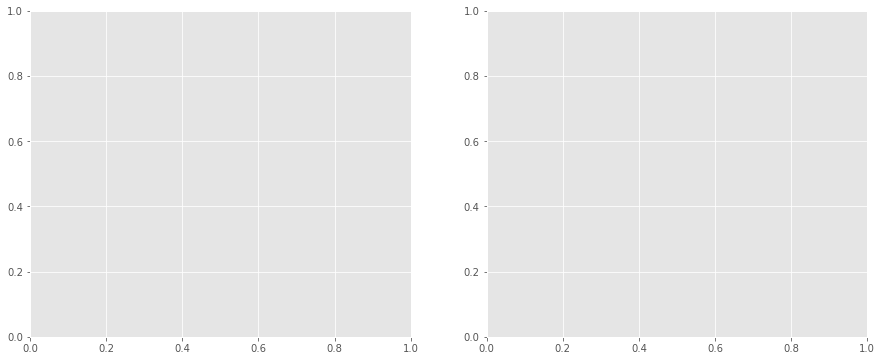

In [20]:
# Plot the predicted error magnitude vs "true" error magnitude
fig, axes = plt.subplots(1,2, figsize=(15,6))
y_pred = LR.predict(x_train_poly)
axes[0].plot(y_train, y_pred, '.r')

# Plot the absolute error
abs_err = np.abs(y_train - y_pred) 
axes[1].plot(abs_err, '.b')

In [ ]:
# Plot error vector's distance-to-center-pixel vs "true " error magnitude 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_train,y_train, '.r')

In [ ]:
# Plot error vector's distance-to-center-pixel vs error velctor angle
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_train, df.err_ang_mx2.as_matrix(), '.r')

In [ ]:
df.head()

In [ ]:
LR.coef_

In [ ]:
LR.intercept_

## Model Evaluation

In [ ]:
    idx_err_r_mx = data.filter(regex=("err_r_" + im_label)).notnull().any(axis=1)
    df_err_r_mx = data.filter(regex=("err_r_" + im_label)).loc[idx_err_r_mx]

    idx_err_ang_mx = data.filter(regex=("err_ang_" + im_label)).notnull().any(axis=1)
    df_err_ang_mx = data.filter(regex=("err_ang_" + im_label)).loc[idx_err_ang_mx]

    idx_err_mag_mx = data.filter(regex=("err_mag_" + im_label)).notnull().any(axis=1)
    df_err_mag_mx = data.filter(regex=("err_mag_" + im_label)).loc[idx_err_mag_mx]
    
    # Join the above dataframes
    df = df_err_r_mx.join(df_err_mag_mx, how="outer")
    df = df.join(df_err_ang_mx, how="outer")